In [1]:
import torch
import numpy
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import imageio 
import io
import pandas as pd 
from scipy.linalg import solve_continuous_are



In [2]:
#state_0, position, min = -1.2, max = 0.6
#state_1, velocity, min = -0.07, max = 0.07
#action: -1 is left, 0 is do nothing, 1 is right
#Default Reward: -1 each time step
#Override reward: (0.5 - position) #0.5 is the goal position

In [3]:
np.arange(-1,1,0.1)

array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
       -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
       -2.00000000e-01, -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
        2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
        6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01])

In [49]:
#state = position, velocity
def get_mountain_car_data(force=0.001,gravity=0.0025):
    #no actions
    data = []
    position_linspace = np.arange(-1.2, 0.6, 0.01)
    velocity_linspace = np.arange(-0.07, 0.07, 0.01)
    actions = np.arange(-1,1,0.1)
    for position in position_linspace:
        for velocity in velocity_linspace:
            for action in actions:
                #action is random float between -1 and 1 
                state = torch.tensor([position, velocity],dtype=torch.float32)
                next_velocity =  velocity + force*(action) - gravity*np.cos(3*position)
                next_position = position + next_velocity
                if next_position < -1.2:
                    next_velocity = 0
                next_state = torch.tensor([next_position, next_velocity],dtype=torch.float32)
                a = torch.tensor([action],dtype=torch.float32)
                reward = -(position - 0.5)**2
                reward = torch.tensor(reward,dtype=torch.float32)
                data.append((state, a, reward, next_state))
    return data

In [50]:
class LQR(nn.Module):
    def __init__(self, enc_dim,state_in_dim, action_in_dim):
        super(LQR, self).__init__()
        self.A = torch.nn.Parameter(torch.randn(enc_dim, enc_dim))
        self.B = torch.nn.Parameter(torch.randn(enc_dim, enc_dim))
        self.Q = torch.nn.Parameter(torch.randn(enc_dim, enc_dim))
        self.R = torch.nn.Parameter(torch.randn(enc_dim, enc_dim))

        self.state_encoder = torch.nn.Sequential(
            torch.nn.Linear(state_in_dim, enc_dim//2),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim//2, enc_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim, enc_dim),
        )

        self.state_decoder = torch.nn.Sequential(
            torch.nn.Linear(enc_dim, enc_dim//2),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim//2, state_in_dim)
        )

        self.action_encoder = torch.nn.Sequential(
            torch.nn.Linear(action_in_dim, enc_dim//2),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim//2, enc_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim, enc_dim),
        )

        self.action_decoder = torch.nn.Sequential(
            torch.nn.Linear(enc_dim, enc_dim//2),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_dim//2, action_in_dim)
        )

    def forward (self,x,u):
        xx = self.state_encoder(x)
        uu = self.action_encoder(u) 

        x_prime_prediction = self.A @ xx + self.B @ uu
        Q_PSD = (self.Q @ self.Q.t()) + 0.01
        R_PSD = (self.R @ self.R.t()) + 0.01
        predicted_reward = -(xx.t() @ Q_PSD @ xx + uu.t() @ R_PSD @ uu)

        decode_action = self.action_decoder(uu)
        return self.state_decoder(x_prime_prediction), x_prime_prediction, xx, decode_action, predicted_reward

In [51]:
def train_model(model,optimizer,train_data_loader,test_data,epochs=1):
    criterion = torch.nn.MSELoss()
    for i in range(epochs):
        total_state_loss = 0
        total_action_loss = 0
        total_reward_loss = 0
        for x, u, r, y in train_data_loader:
            x = x.squeeze(0)
            y = y.squeeze(0)
            u = u.squeeze(0)
            r = r.squeeze(0)
            optimizer.zero_grad()
            lqr_x_prime, x_prime_expanded, xx, lqr_u_decode, lqr_reward_pred = model(x,u)
            lqr_pred_loss = criterion(lqr_x_prime, y) #Consider Taking this out
            decoder_loss = criterion(model.state_decoder(xx), x)    #can also try only lqr loss and auto encode loss (remove enc loss)
            encoder_loss = criterion(model.state_encoder(y), x_prime_expanded) 
            action_loss = criterion(lqr_u_decode, u)
            total_action_loss += action_loss.item()
            state_loss = lqr_pred_loss  + decoder_loss + encoder_loss
            reward_loss = criterion(lqr_reward_pred, r)
            total_reward_loss += reward_loss.item()
            loss = state_loss + action_loss + reward_loss
            loss.backward()
            optimizer.step()
            total_state_loss += state_loss.item()
        test_state_loss = 0 
        test_action_loss = 0
        test_reward_loss = 0
        for x,u,r,y in test_data:
            with torch.no_grad():
                x = x.squeeze(0)
                y = y.squeeze(0)
                lqr_x_prime, x_prime_expanded, xx, lqr_u_decode, lqr_reward_pred = model(x,u)
                lqr_pred_loss = criterion(lqr_x_prime, y)
                decoder_loss = criterion(model.state_decoder(xx), x)
                encoder_loss = criterion(model.state_encoder(y), x_prime_expanded) 
                action_loss = criterion(lqr_u_decode, u)
                test_action_loss += action_loss.item()
                state_loss = lqr_pred_loss  + decoder_loss + encoder_loss
                test_state_loss += state_loss.item()
                reward_loss = criterion(lqr_reward_pred, r)
                test_reward_loss += reward_loss.item()
        print(f"Epoch {i} Train State Loss: {total_state_loss/len(train_data_loader)} Action Loss: {total_action_loss/len(train_data_loader)} Reward Loss: {total_reward_loss/len(train_data_loader)} Test State Loss: {test_state_loss/len(test_data)} Test Action Loss: {test_action_loss/len(test_data)} Test Reward Loss: {test_reward_loss/len(test_data)}")

In [52]:
all_data = get_mountain_car_data()
random.shuffle(all_data)
train_data = all_data[:int(len(all_data)*0.8)]
test_data = all_data[int(len(all_data)*0.8):]
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
print(f"Train Data Length: {len(train_data)}")
print(f"Test Data Length: {len(test_data)}")


Train Data Length: 43200
Test Data Length: 10800


In [53]:
model = LQR(64,2,1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [54]:
train_model(model,optimizer,train_data_loader,test_data,epochs=8)

Epoch 0 Train State Loss: 0.008701956220665866 Action Loss: 0.0025182758532071047 Reward Loss: 1.3193334461619637 Test State Loss: 0.00024125631568191845 Test Action Loss: 0.00013580672199299795 Test Reward Loss: 3.663946730006256e-05
Epoch 1 Train State Loss: 0.0008104037274198475 Action Loss: 0.00026711209674700815 Reward Loss: 0.0013842272794839998 Test State Loss: 0.0002649439872907856 Test Action Loss: 6.6399604811753876e-06 Test Reward Loss: 0.0001852528149992636
Epoch 2 Train State Loss: 0.000516712718832503 Action Loss: 0.00019374697377508976 Reward Loss: 0.0009357535383044647 Test State Loss: 0.00016284784527265906 Test Action Loss: 4.662321249208685e-06 Test Reward Loss: 2.3995534871835777e-05
Epoch 3 Train State Loss: 0.00040690787069032894 Action Loss: 0.00012576282151525534 Reward Loss: 0.0006850328261813955 Test State Loss: 4.388370149357528e-05 Test Action Loss: 4.252280569651837e-05 Test Reward Loss: 9.496557206479716e-06
Epoch 4 Train State Loss: 0.00030712025290595624

In [ ]:
# #save model
#torch.save(model.state_dict(), "lqr_model_64_8_epochs")
#load model
#model.load_state_dict(torch.load("lqr_model_64_12_epochs"))

## Value Iteration Compare

In [10]:
-0.07 + 0.001 - 0.0025*np.cos(3*-1.2)

-0.06675810395916464

In [369]:
(-0.07 - 0.1 - 0.0025*np.cos(3*-0.9))

-0.16773981964495735

In [363]:
-0.0025*np.cos(3*-1.2) 

0.0022418960408353682

In [ ]:
starting_positions = np.arange(-0.9, 0.4, 0.01) #up to 0.4 since no point in starting past goal
starting_velocities = np.arange(-0.07, 0.07, 0.01)
position = -0.9
velocity = -0.07
curr_position = position
curr_velocity = velocity
count = 0
while curr_position < 0.5 and count < 100:
    if curr_velocity < 0 and np.cos(curr_position) < 0.9:
        optimal_action = -1 #left
    else:
        optimal_action = 1 #right
    next_velocity =  curr_velocity + 0.001*(optimal_action) - 0.0025*np.cos(3*curr_position)
    next_position = curr_position + next_velocity
    curr_position = next_position
    count += 1




In [41]:
for starting_positions in np.arange(-1.2, 0.4, 0.01): 
    for starting_velocities in np.arange(-0.07, 0.07, 0.01):

        curr_position = position
        curr_velocity = velocity
        count = 0
        while curr_position < 0.5 and count < 1000:
            if curr_velocity < 0: #Stop moving left if getting close to left peak
                optimal_action = -1  # Push left when moving left to build momentum
            else:
                optimal_action = 1  # Otherwise, push right to gain speed

            next_velocity = (curr_velocity) + (0.001 * optimal_action) - (0.0025 * np.cos(3 * curr_position))

            next_position = curr_position + next_velocity
            if next_position < -1.2:
                next_velocity = 0
            #next_position = np.clip(next_position, -1.2, 0.6)  # Enforce position limits
            #next_velocity = np.clip(next_velocity, -0.07, 0.07)  # Enforce velocity limits
            # Update current state
            curr_position = next_position
            curr_velocity = next_velocity

            count += 1
            if curr_position > 0.5:
                print("Success!")
            if count == 1000:
                print("Failed")

Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
S

Success!


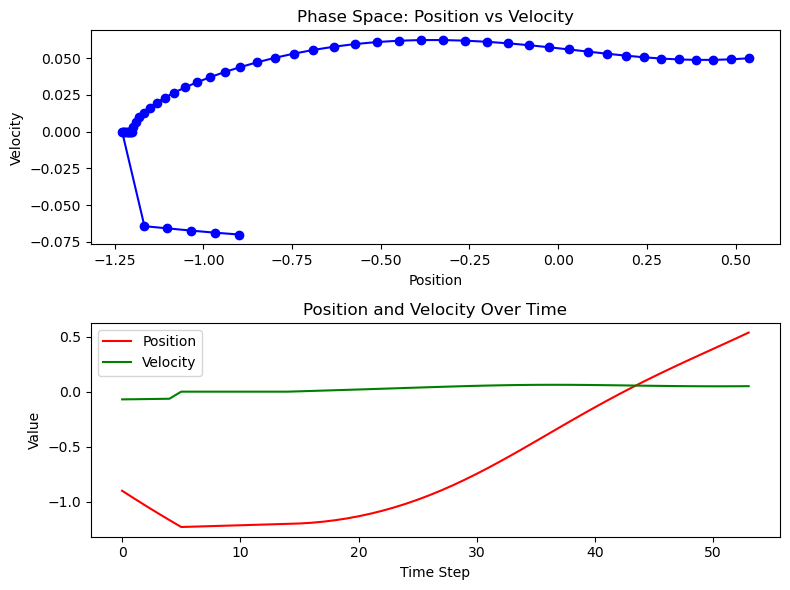

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize variables
position = -0.9
velocity = -0.07
curr_position = position
curr_velocity = velocity
count = 0

# Store trajectories
positions = [curr_position]
velocities = [curr_velocity]

while curr_position < 0.5 and count < 1000:
    if curr_velocity < 0:
        optimal_action = -1  # Push left when moving left to build momentum
    else:
        optimal_action = 1  # Otherwise, push right to gain speed

    next_velocity = (curr_velocity) + (0.001 * optimal_action) - (0.0025 * np.cos(3 * curr_position))
    next_position = curr_position + next_velocity
    if next_position < -1.2:
        next_velocity = 0
    #next_position = np.clip(next_position, -1.2, 0.6)  # Enforce position limits
    #next_velocity = np.clip(next_velocity, -0.07, 0.07)  # Enforce velocity limits
    # Update current state
    curr_position = next_position
    curr_velocity = next_velocity

    # Store values
    positions.append(curr_position)
    velocities.append(curr_velocity)
    count += 1
    if curr_position > 0.5:
        print("Success!")

# Create plots
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

# Position vs Velocity (Phase Space)
axs[0].plot(positions, velocities, marker='o', linestyle='-', color='b')
axs[0].set_xlabel("Position")
axs[0].set_ylabel("Velocity")
axs[0].set_title("Phase Space: Position vs Velocity")

# Time Series
axs[1].plot(range(len(positions)), positions, label="Position", color='r')
axs[1].plot(range(len(velocities)), velocities, label="Velocity", color='g')
axs[1].set_xlabel("Time Step")
axs[1].set_ylabel("Value")
axs[1].set_title("Position and Velocity Over Time")
axs[1].legend()

plt.tight_layout()
plt.show()


In [45]:
count

1000

In [108]:
starting_positions = np.arange(-0.9, 0.4, 0.01) #up to 0.4 since no point in starting past goal
starting_velocities = np.arange(-0.07, 0.07, 0.01)
log = {}
for position in starting_positions:
    for velocity in starting_velocities: 
        log[(position,velocity)] = {"True Rewards": [], "Model Rewards": [], "Success": False}
        curr_position = position
        curr_velocity = velocity
        rewards = []
        #print(position,velocity)
        while curr_position < 0.5:
            #print("Current Position", curr_position)
            #print("Current Velocity", curr_velocity)
            if curr_velocity < 0:
                optimal_action = -1 #left
            else:
                optimal_action = 1 #right
            next_velocity =  curr_velocity + 0.001*(optimal_action) - 0.0025*np.cos(3*curr_position)
            # print(next_velocity > -0.07, next_velocity > 0)
            # print(curr_velocity, curr_position, optimal_action)
            # print(curr_velocity + 0.1*(optimal_action)) 
            # print(-0.0025*np.cos(3*curr_position))
            # print(next_velocity)
            # raise ValueError
            next_position = curr_position + next_velocity
            if next_position < -1.2:
                    next_velocity = 0
            #print("Next Position", next_position)
            #print("Next Velocity", next_velocity)
            reward = -(next_position - 0.5)**2
            rewards.append(reward)
            curr_position = next_position
            curr_velocity = next_velocity
        log[(position,velocity)]["True Rewards"] = rewards
        curr_position = position
        curr_velocity = velocity
        true_time = len(rewards)
        rewards = []
        counter = 0
        while curr_position < 0.5 and counter < true_time * 100:
            state = torch.tensor([curr_position, curr_velocity],dtype=torch.float32)
            if curr_velocity < 0:
                optimal_action = torch.tensor([-1],dtype=torch.float32)
            else:
                optimal_action = torch.tensor([1],dtype=torch.float32)
            with torch.no_grad():
                next_state, _, _, _, predicted_reward = model(state,optimal_action)
            next_position = next_state[0].item()
            next_velocity = next_state[1].item()
            #reward = predicted_reward.item()
            reward = -(next_position - 0.5)**2
            rewards.append(reward)
            curr_position = next_position
            curr_velocity = next_velocity
            counter += 1
        log[(position,velocity)]["Model Rewards"] = rewards
        if curr_position >= 0.5:
            log[(position,velocity)]["Success"] = True
        

In [109]:
reward_sums = []
for key in log:
    reward_sums.append([sum(log[key]["True Rewards"]),sum(log[key]["Model Rewards"])])
df = pd.DataFrame(reward_sums, columns=["True Rewards", "Model Rewards"])


In [110]:
df["abs_diff"] = abs(df["True Rewards"] - df["Model Rewards"])


In [111]:
df

,True Rewards,Model Rewards,abs_diff
0,-87.208301,-70.107645,17.100656
1,-89.892779,-69.821287,20.071492
2,-74.308052,-65.768786,8.539265
3,-93.735896,-62.656156,31.079740
4,-96.882191,-58.516249,38.365942
...,...,...,...
1945,-0.009382,-0.015494,0.006112
1946,-0.005903,-0.009838,0.003935
1947,-0.005418,-0.006118,0.000700
1948,-0.002608,-0.006042,0.003434


In [112]:
reward_lens = []
for key in log:
    reward_lens.append([len(log[key]["True Rewards"]),len(log[key]["Model Rewards"])])
df = pd.DataFrame(reward_lens, columns=["True Rewards", "Model Rewards"])
df.head()

,True Rewards,Model Rewards
0,53,53
1,54,53
2,49,52
3,56,51
4,58,50


In [113]:
df["abs_diff"] = abs(df["True Rewards"] - df["Model Rewards"])

In [114]:
reward_lens = []
for key in log:
    reward_lens.append([len(log[key]["True Rewards"]),len(log[key]["Model Rewards"])])
df_og = pd.DataFrame(reward_lens, columns=["True Rewards", "Model Rewards"])
df_og["abs_diff"] = abs(df["True Rewards"] - df["Model Rewards"])

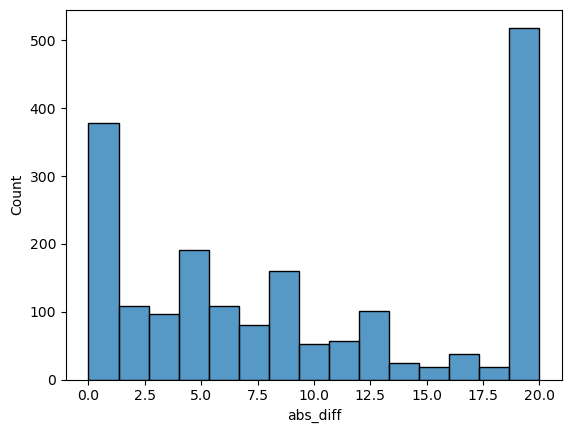

In [115]:

#group by abs_diff and show relative count
df = df_og.copy()#if greater than max val
max_val = 20
df["abs_diff"] = df["abs_diff"].apply(lambda x: x if x < max_val else max_val)
df["abs_diff"].value_counts(ascending=False)
#plot histogram
sns.histplot(df["abs_diff"], bins=15)
plt.show()



In [ ]:
#Heatmap of value function (for each initial position and velocity, get discounted sum of rewards at -- value function) 
#Compare value function of model to true dynamics, compare side by side as heatmaps
#Compare to randomly initialized learned model as 3rd heatmap
#See where learned model ends up transitioning to vs true transition (start at point A and run for N timesteps)
#Measure rate of divergence as each model goes through timesteps

<Axes: ylabel='Frequency'>

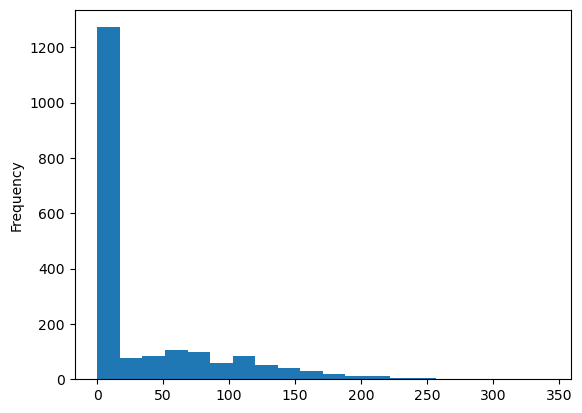

In [78]:
df['abs_diff'].plot.hist(bins=20)

<Axes: ylabel='Frequency'>

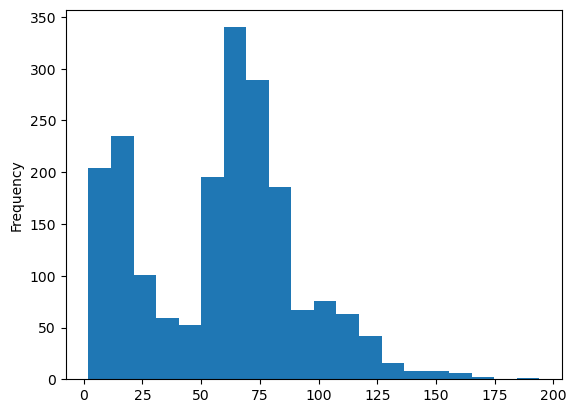

In [79]:
df['True Rewards'].plot.hist(bins=20)

<Axes: ylabel='Frequency'>

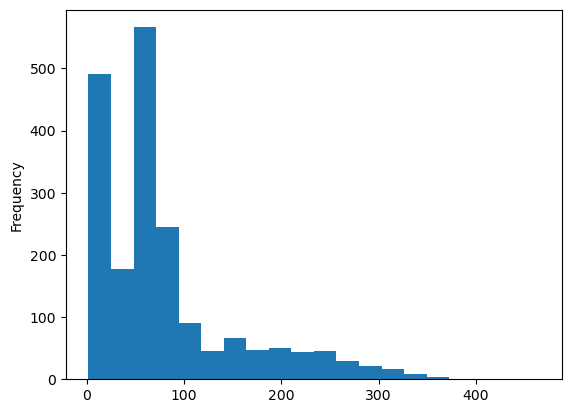

In [80]:
df['Model Rewards'].plot.hist(bins=20)

## Error Heatmap

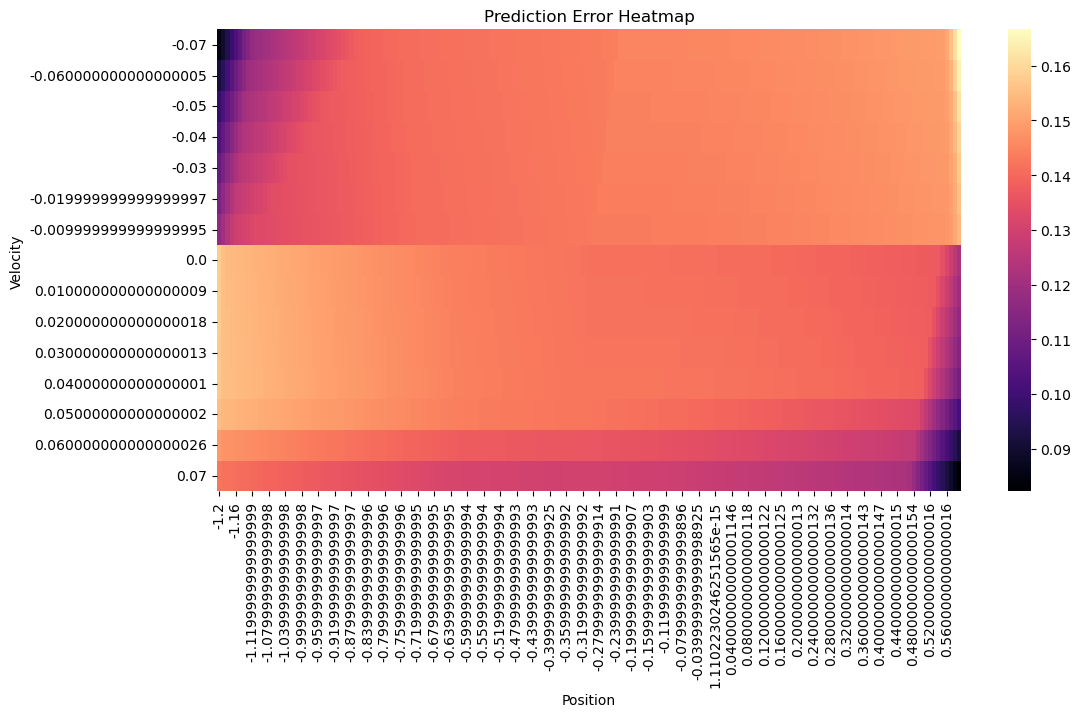

In [309]:
true_ns_pred_ns = []

for position in np.arange(-1.2, 0.6, 0.01):
    for velocity in np.arange(-0.07, 0.07, 0.01):
        optimal_action = -1 if velocity < 0 else 1
        state = torch.tensor([position, velocity], dtype=torch.float32)
        action = torch.tensor([optimal_action], dtype=torch.float32)
        true_next_state = state + torch.tensor(
            [velocity + 0.001 * (optimal_action) - 0.0025 * np.cos(3 * position), 0], dtype=torch.float32
        )
        with torch.no_grad():
            next_state_pred, _, _, _, _ = model(state, action)

        error = np.linalg.norm([
            true_next_state[0].item() - next_state_pred[0].item(),
            true_next_state[1].item() - next_state_pred[1].item()
        ])

        true_ns_pred_ns.append((position, velocity, error))

# Convert to DataFrame
df = pd.DataFrame(true_ns_pred_ns, columns=["position", "velocity", "error"])

# Pivot for heatmap
heatmap_data = df.pivot(index="velocity", columns="position", values="error")

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="magma", cbar=True)
plt.xlabel("Position")
plt.ylabel("Velocity")
plt.title("Prediction Error Heatmap")
plt.show()


In [310]:
#sample random state
random_position = random.uniform(-1.2, 0.6)
random_velocity = random.uniform(-0.07, 0.07)

In [326]:
for action in [-0.5,0,0.5]:
    with torch.no_grad():
        state = torch.tensor([random_position, random_velocity],dtype=torch.float32)
        action = torch.tensor([action],dtype=torch.float32)
        true_next_state = torch.tensor([random_position + random_velocity, random_velocity + 0.001*(action) - 0.0025*np.cos(3*random_position)],dtype=torch.float32)
        lqr_x_prime, x_prime_expanded, xx, lqr_u_decode, lqr_reward_pred = model(state,action)
        print(f"Action Taken: {action}")
        print(f"True Next State: {true_next_state}")
        print(f"Predicted Next State: {lqr_x_prime}")
        print(f"Loss: {torch.nn.MSELoss()(lqr_x_prime, true_next_state)}")

Action Taken: tensor([-0.5000])
True Next State: tensor([-0.5974, -0.0359])
Predicted Next State: tensor([-0.6438, -0.0757])
Loss: 0.0018692549783736467
Action Taken: tensor([0.])
True Next State: tensor([-0.5974, -0.0354])
Predicted Next State: tensor([-0.5979, -0.0282])
Loss: 2.5928402465069667e-05
Action Taken: tensor([0.5000])
True Next State: tensor([-0.5974, -0.0349])
Predicted Next State: tensor([-0.5521,  0.0193])
Loss: 0.0024951393716037273


In [ ]:
#try solving LQR iteratively and inspect
#Hardcode optimal policy, calculate the value 
#x_t+1 = Ax_t + Bu_t, u_t is hardcoded as pi(x_t), simulate until episode end and rewards collected along way
#Compare that to true dynamics of using (x_t+1 = f(xt_ut)) 

#Compare Ku to regular u 

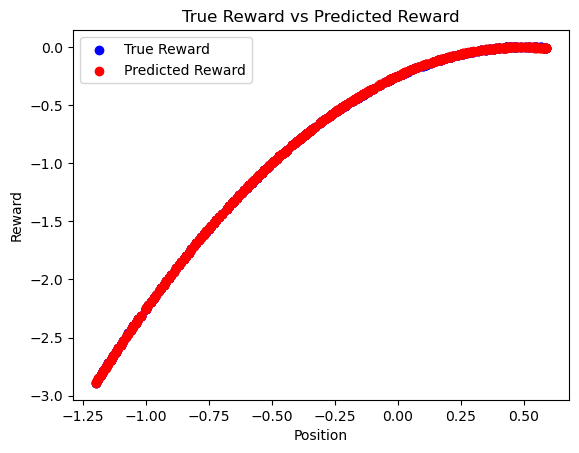

In [325]:
true_reward_pred_reward = []
for x,u,r,y in test_data:
    with torch.no_grad():
        x = x.squeeze(0)
        y = y.squeeze(0)
        lqr_x_prime, x_prime_expanded, xx, lqr_u_decode, lqr_reward_pred = model(x,u)
        true_reward_pred_reward.append((x[0].item(),r.item(),lqr_reward_pred.item()))
true_reward_pred_reward = np.array(true_reward_pred_reward)
#make true blue, pred red
plt.scatter(true_reward_pred_reward[:,0],true_reward_pred_reward[:,1],color='blue')
plt.scatter(true_reward_pred_reward[:,0],true_reward_pred_reward[:,2],color='red')
plt.xlabel("Position")
plt.ylabel("Reward")
plt.legend(["True Reward","Predicted Reward"])
plt.title("True Reward vs Predicted Reward")
plt.show()

## Getting K

In [313]:
#state = position, velocity
def get_mountain_car_data_optimal_policy(force=0.001,gravity=0.0025):
    #no actions
    data = []
    position_linspace = np.arange(-1.2, 0.6, 0.01)
    velocity_linspace = np.arange(-0.07, 0.07, 0.01)
    for position in position_linspace:
        for velocity in velocity_linspace:
            #action should be optimal action
            if velocity < 0:
                action = -1
            else:
                action = 1
            state = torch.tensor([position, velocity],dtype=torch.float32)
            #nv = v + .001*(actions - 1) - .0025*np.cos(3*x) #changed action to 0
            next_velocity =  velocity + force*(action) - gravity*np.cos(3*position)
            next_position = position + next_velocity
            next_state = torch.tensor([next_position, next_velocity],dtype=torch.float32)
            a = torch.tensor([action],dtype=torch.float32)
            #reward = torch.tensor((0 - next_position),dtype=torch.float32)
            reward = -(position - 0.5)**2
            reward = torch.tensor(reward,dtype=torch.float32)
            data.append((state, a, reward, next_state,velocity))
    return data

In [314]:
trained_A = model.A.detach().numpy()
trained_B = model.B.detach().numpy()
trained_Q = model.Q.detach().numpy()
trained_R = model.R.detach().numpy()
trained_Q_PSD = (trained_Q @ trained_Q.T) +0.1
trained_R_PSD = (trained_R @ trained_R.T) +0.1


P = solve_continuous_are(trained_A,trained_B,trained_Q_PSD,trained_R_PSD)
K = np.linalg.inv(trained_R_PSD) @ trained_B.T @ P

In [315]:
print("Trained A Max", np.max(trained_A), "Min", np.min(trained_A), "Mean", np.mean(trained_A))
print("Trained B Max", np.max(trained_B), "Min", np.min(trained_B), "Mean", np.mean(trained_B))
print("Trained Q_PSD Max", np.max(trained_Q_PSD), "Min", np.min(trained_Q_PSD), "Mean", np.mean(trained_Q_PSD))
print("Trained R_PSD Max", np.max(trained_R_PSD), "Min", np.min(trained_R_PSD), "Mean", np.mean(trained_R_PSD))
print("P Max", np.max(P), "Min", np.min(P), "Mean", np.mean(P))
print("K Max", np.max(K), "Min", np.min(K), "Mean", np.mean(K))


Trained A Max 2.7556005 Min -2.5800083 Mean -0.0032526068
Trained B Max 2.6298623 Min -2.4521742 Mean -0.052645665
Trained Q_PSD Max 37.866993 Min -15.768028 Mean 1.4975531
Trained R_PSD Max 28.224117 Min -10.937682 Mean 0.6737909
P Max 13.086247100601241 Min -3.741345678391264 Mean 0.2701726971465243
K Max 41.535361057712386 Min -50.911268949051745 Mean 0.010631583264875658


In [316]:
#check if Q_PSD = Q_PSD.T
print(np.allclose(trained_Q_PSD,trained_Q_PSD.T))
print(np.allclose(trained_R_PSD,trained_R_PSD.T))

True
True


In [317]:
#check if Q_PSD is positive definite
print(np.linalg.eigvals(trained_Q_PSD)>0)
print(np.linalg.eigvals(trained_R_PSD)>0)
#print(np.linalg.eigvals(trained_R_PSD))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


In [318]:
pred_action_vs_true = []
optimal_policy_data = get_mountain_car_data_optimal_policy()
##Need policy data
for i in optimal_policy_data:
    x,u,r,y,v = i
    with torch.no_grad():
        x = x.squeeze(0)
        y = y.squeeze(0)
        lqr_x_prime, x_prime_expanded, xx, lqr_u_decode, lqr_reward_pred = model(x,u)
        pred_action = -K @ xx.numpy()

        pred_action = model.action_decoder(torch.tensor(pred_action,dtype=torch.float32)).numpy()
        if pred_action.item() > 0:
            pred_action = 1
        else:
            pred_action = -1
        pred_action_vs_true.append([v,u.item(), pred_action])

In [319]:
pred_action_vs_true[0]

[-0.07, -1.0, 1]

In [320]:
import pandas as pd 

In [321]:
data = pd.DataFrame(pred_action_vs_true,columns=["Velocity","True Action","Predicted Action"])
data["Correct"] = data["True Action"] == data["Predicted Action"]
data["Correct"].sum()/len(data)

0.5048148148148148

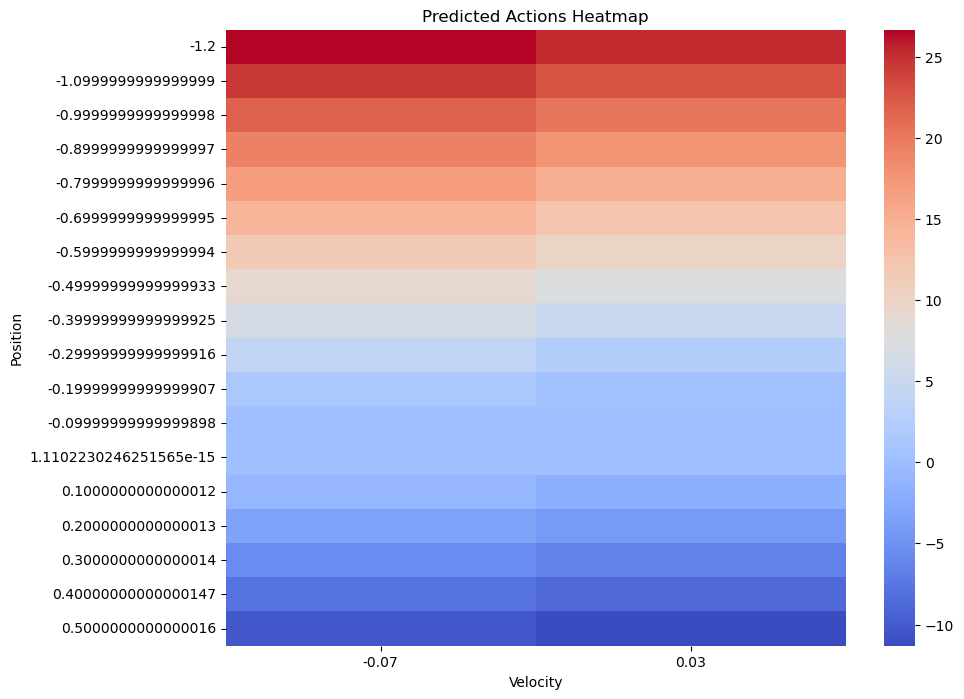

,position,velocity,action
count,36.000000,36.000000,36.000000
mean,-0.350000,-0.020000,6.531952
std,0.526172,0.050709,11.110028
min,-1.200000,-0.070000,-11.307078
25%,-0.800000,-0.070000,-1.041779
50%,-0.350000,-0.020000,4.423338
75%,0.100000,0.030000,15.513167
max,0.500000,0.030000,26.651863


In [322]:
true_velocities = np.arange(-0.07,0.07,0.1)
true_positions = np.arange(-1.2,0.6,0.1)
output_actions = []
for p in true_positions: 
    for v in true_velocities:
        x = torch.tensor([p,v],dtype=torch.float32)
        xx = model.state_encoder(x)
        pred_action = -K @ xx.detach().numpy()
        pred_action = model.action_decoder(torch.tensor(pred_action,dtype=torch.float32).detach()).detach().numpy()
        # if pred_action.item() > 1:
        #     pred_action = 2
        # else:
        #     pred_action = 0
        pred_action = pred_action.item()
        #print(pred_action)
        output_actions.append([p,v,pred_action])
# Given values
true_velocities = np.arange(-0.07, 0.07, 0.1)
true_positions = np.arange(-1.2, 0.6, 0.1)

# Create a DataFrame
df = pd.DataFrame(output_actions, columns=["position", "velocity", "action"])

# Pivot the data for heatmap (rows: positions, columns: velocities)
heatmap_data = df.pivot(index="position", columns="velocity", values="action")

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=False, cbar=True)
plt.title("Predicted Actions Heatmap")
plt.xlabel("Velocity")
plt.ylabel("Position")
plt.show()

df.describe()


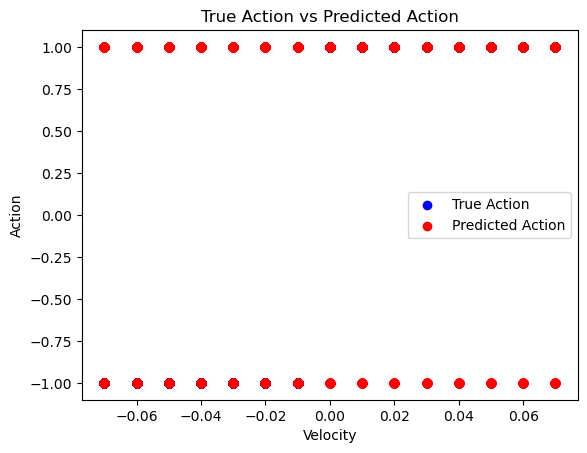

In [323]:
#scatter plot with velocity as x axis. Blue is true action, red is predicted action
pred_action_vs_true = np.array(pred_action_vs_true)
plt.scatter(pred_action_vs_true[:,0],pred_action_vs_true[:,1],color='blue')
plt.scatter(pred_action_vs_true[:,0],pred_action_vs_true[:,2],color='red')
plt.xlabel("Velocity")
plt.ylabel("Action")
plt.legend(["True Action","Predicted Action"])
plt.title("True Action vs Predicted Action")
plt.show()

[[1.         0.99999514]
 [0.99999514 1.        ]]


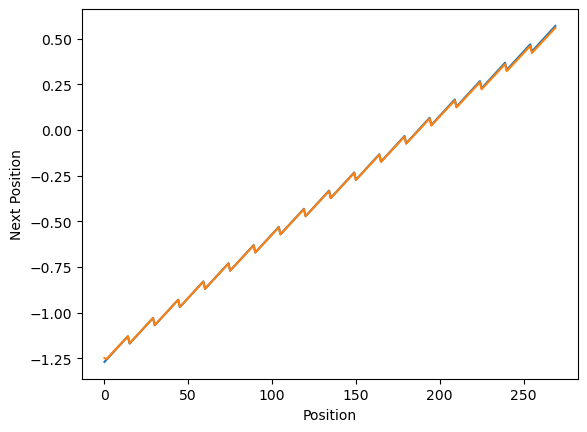

[[1.        0.9995733]
 [0.9995733 1.       ]]


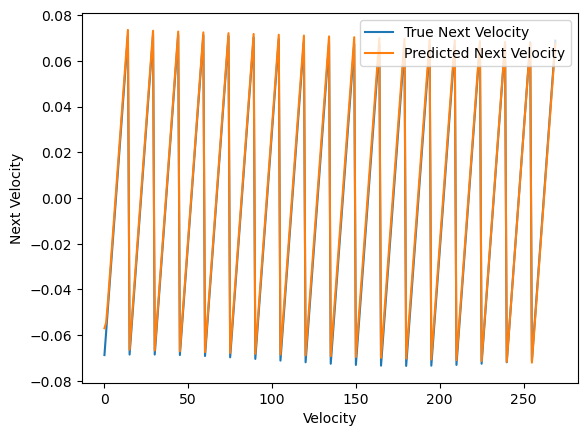

In [10]:
#plot true position compared to model position prediction

def plot_position(model,ax=None):
    true_positions = np.arange(-1.2, 0.6, .1)
    velocities = np.arange(-0.07, 0.07, .01)
    true_next_positions = []
    true_next_velocities = []
    for i in true_positions:
        for j in velocities: 
            nv = j + .001*(0 - 1) - .0025*np.cos(3*i)
            nx = i + nv
            true_next_positions.append(nx)
            true_next_velocities.append(nv)
   # print(len(true_next_positions))
    pred_next_positions = []
    pred_next_velocities = []
    for i in true_positions:
        for j in velocities:
            next,_,_ = model(torch.tensor([i, j],dtype=torch.float32))
            nx, nv = next
            pred_next_positions.append(nx.item())
            pred_next_velocities.append(nv.item())

    #print(len(pred_next_positions[0]))
    plt.plot(true_next_positions, label='True Next Position')
    plt.plot(pred_next_positions, label='Predicted Next Position')
    #get correlation
    print(np.corrcoef(true_next_positions,pred_next_positions))
    plt.xlabel('Position')
    plt.ylabel('Next Position')
    plt.show()

    plt.plot(true_next_velocities, label='True Next Velocity')
    plt.plot(pred_next_velocities, label='Predicted Next Velocity')
    print(np.corrcoef(true_next_velocities,pred_next_velocities))
    plt.xlabel('Velocity')
    plt.ylabel('Next Velocity')
    plt.legend()
    plt.show()

plot_position(model)

[[1.         0.99999514]
 [0.99999514 1.        ]]


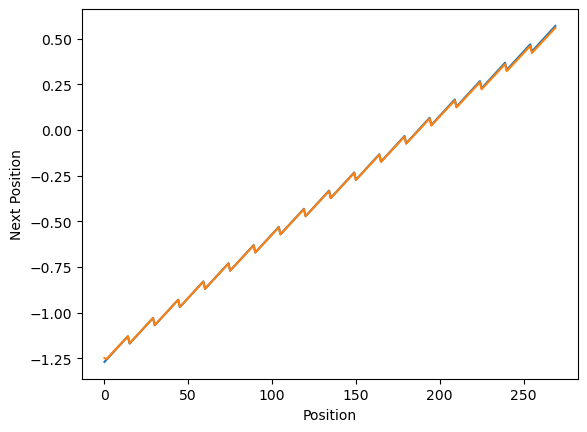

[[1.        0.9995733]
 [0.9995733 1.       ]]


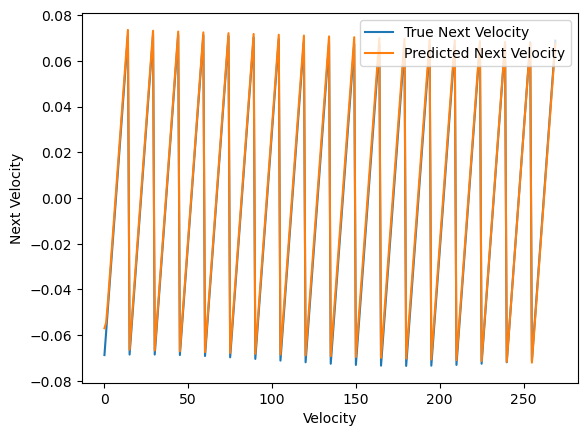

In [ ]:
#plot true position compared to model position prediction

def plot_position(model,ax=None):
    true_positions = np.arange(-1.2, 0.6, .1)
    velocities = np.arange(-0.07, 0.07, .01)
    true_next_positions = []
    true_next_velocities = []
    for i in true_positions:
        for j in velocities: 
            nv = j + .001*(0 - 1) - .0025*np.cos(3*i)
            nx = i + nv
            true_next_positions.append(nx)
            true_next_velocities.append(nv)
   # print(len(true_next_positions))
    pred_next_positions = []
    pred_next_velocities = []
    for i in true_positions:
        for j in velocities:
            next,_,_ = model(torch.tensor([i, j],dtype=torch.float32))
            nx, nv = next
            pred_next_positions.append(nx.item())
            pred_next_velocities.append(nv.item())

    #print(len(pred_next_positions[0]))
    plt.plot(true_next_positions, label='True Next Position')
    plt.plot(pred_next_positions, label='Predicted Next Position')
    #get correlation
    print(np.corrcoef(true_next_positions,pred_next_positions))
    plt.xlabel('Position')
    plt.ylabel('Next Position')
    plt.show()

    plt.plot(true_next_velocities, label='True Next Velocity')
    plt.plot(pred_next_velocities, label='Predicted Next Velocity')
    print(np.corrcoef(true_next_velocities,pred_next_velocities))
    plt.xlabel('Velocity')
    plt.ylabel('Next Velocity')
    plt.legend()
    plt.show()

plot_position(model)